In [1]:
import utz
from utz import *
from utz.plots import symbols
from benchmarks.cli.data_loader import DEFAULT_DB_PATH, METHODS, TBL

In [2]:
db_path = DEFAULT_DB_PATH  # SQL db path to read epoch stats from
tbl = TBL                  # SQL table name to read epoch stats from
out_dir = None             # Directory to save plot PNG/JSON to (e.g. "m3", "azl")
host = None                # Description of host the stats were collected on, used in plot subtitle (e.g. "M3 Mac", "Amazon Linux")
show = None                # Set to "png" to render plots in notebook as PNGs (good for noninteractive mode / Git-committing)
hostname = None            # Filter DB "hostname" field to values matching this regex
W = 1000                   # Output plot width
H =  600                   # Output plot height
proportional_symbol_size = "2em"  # "∝" is tiny on Mac, by default

In [3]:
# Parameters
out_dir = "azl"
show = "png"
host = "EC2 (g4dn.8xlarge)"
hostname = "us-west-2"
W = 1200
H = 800
proportional_symbol_size = "1em"


In [4]:
db_uri = f'sqlite:///{db_path}'
df = pd.read_sql_table(tbl, db_uri)
if hostname:
    df = df[df.hostname.str.contains(hostname)].reset_index(drop=True).copy()
df

,start,epoch,n_rows,n_cols,elapsed,gc,max_mem,alb_start,sha,user,hostname,uri,method,batch_size,soma_chunk_size,shuffle_chunk_count,py_buffer_size,soma_buffer_size
0,2024-06-06 20:16:37.252276,0,132766,20000,24.587138,2.351868,7777726464,2024-06-06 20:16:37.221000,f532aa0dd14befd0ab700ddc86f3a36649c6b548,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,64,256,1073741824,1073741824
1,2024-06-06 20:17:04.435461,1,132766,20000,21.281682,2.464279,9689788416,2024-06-06 20:16:37.221000,f532aa0dd14befd0ab700ddc86f3a36649c6b548,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,64,256,1073741824,1073741824
2,2024-06-06 20:17:28.437413,2,132766,20000,21.647326,2.237613,9620484096,2024-06-06 20:16:37.221000,f532aa0dd14befd0ab700ddc86f3a36649c6b548,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,64,256,1073741824,1073741824
3,2024-06-06 20:17:52.797947,3,132766,20000,21.281913,2.473912,9624256512,2024-06-06 20:16:37.221000,f532aa0dd14befd0ab700ddc86f3a36649c6b548,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,64,256,1073741824,1073741824
4,2024-06-06 20:18:16.659317,4,132766,20000,21.168530,2.415138,9726382080,2024-06-06 20:16:37.221000,f532aa0dd14befd0ab700ddc86f3a36649c6b548,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,64,256,1073741824,1073741824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2024-06-07 02:28:05.515038,0,132766,20000,40.190372,2.125860,8905838592,2024-06-07 01:39:11.578593,fb5c70a768df73dfe8a165a1ecfdc8f3e3136bbc,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,16384,2,1073741824,1073741824
256,2024-06-07 02:28:56.872709,1,132766,20000,42.724046,2.093980,8015974400,2024-06-07 01:39:11.578593,fb5c70a768df73dfe8a165a1ecfdc8f3e3136bbc,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,16384,2,1073741824,1073741824
257,2024-06-07 02:29:47.996699,2,132766,20000,41.156797,2.175608,9535000576,2024-06-07 01:39:11.578593,fb5c70a768df73dfe8a165a1ecfdc8f3e3136bbc,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,16384,2,1073741824,1073741824
258,2024-06-07 02:30:38.351547,3,132766,20000,43.231266,2.000631,8116596736,2024-06-07 01:39:11.578593,fb5c70a768df73dfe8a165a1ecfdc8f3e3136bbc,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,16384,2,1073741824,1073741824


In [5]:
# df.to_sql(tbl, db_uri, if_exists='replace', index=False)

In [6]:
hist = df[['hostname', 'method', 'shuffle_chunk_count', 'soma_chunk_size']].value_counts().sort_index().rename('num')
hist

hostname                                    method     shuffle_chunk_count  soma_chunk_size
ip-172-31-0-157.us-west-2.compute.internal  np.array   1                    8192               5
                                                                            16384              5
                                                       2                    4096               5
                                                                            8192               5
                                                                            16384              5
                                                       4                    2048               5
                                                                            4096               5
                                                                            8192               5
                                                       8                    1024               5
                                   

In [7]:
pivoted = hist.reset_index(level=[0,1]).pivot(columns=['hostname', 'method'], values='num')
assert (pivoted == 5).all().all()
pivoted

hostname                            ip-172-31-0-157.us-west-2.compute.internal  \
method                                                                np.array   
shuffle_chunk_count soma_chunk_size                                              
1                   8192                                                     5   
                    16384                                                    5   
2                   4096                                                     5   
                    8192                                                     5   
                    16384                                                    5   
4                   2048                                                     5   
                    4096                                                     5   
                    8192                                                     5   
8                   1024                                                     5   
                    2048                                                     5   
                    4096                                                     5   
16                  512                                                      5   
                    1024                                                     5   
                    2048                                                     5   
32                  256                                                      5   
                    512                                                      5   
                    1024                                                     5   
64                  128                                                      5   
                    256                                                      5   
                    512                                                      5   
128                 64                                                       5   
                    128                                                      5   
                    256                                                      5   
256                 64                                                       5   
                    128                                                      5   
512                 64                                                       5   

hostname                                       
method                              scipy.csr  
shuffle_chunk_count soma_chunk_size            
1                   8192                    5  
                    16384                   5  
2                   4096                    5  
                    8192                    5  
                    16384                   5  
4                   2048                    5  
                    4096                    5  
                    8192                    5  
8                   1024                    5  
                    2048                    5  
                    4096                    5  
16                  512                     5  
                    1024                    5  
                    2048                    5  
32                  256                     5  
                    512                     5  
                    1024                    5  
64                  128                     5  
                    256                     5  
                    512                     5  
128                 64                      5  
                    128                     5  
                    256                     5  
256                 64                      5  
                    128                     5  
512                 64                      5

In [8]:
df['block_size'] = df.soma_chunk_size * df.shuffle_chunk_count
df['block_size_lg2'] = df['block_size'].apply(log2).astype(int)
block_lg2_vals = df['block_size_lg2'].unique().tolist()
block_lg2_vals.sort()
min_block_lg2, max_block_lg2 = min(block_lg2_vals), max(block_lg2_vals)
min_block_lg2, max_block_lg2, block_lg2_vals

(13, 15, [13, 14, 15])

In [9]:
df['chunk_lg2'] = df.soma_chunk_size.apply(log2)
chunk_lg2_vals = df.chunk_lg2.apply(int).unique().tolist()
chunk_lg2_vals.sort()
min_chunk_log2, max_chunk_log2 = min(chunk_lg2_vals), max(chunk_lg2_vals)
min_chunk_log2, max_chunk_log2, chunk_lg2_vals

(6, 14, [6, 7, 8, 9, 10, 11, 12, 13, 14])

In [10]:
df['count_lg2'] = df.shuffle_chunk_count.apply(log2).apply(int)
counts_lg2_vals = df.count_lg2.unique().tolist()
counts_lg2_vals.sort()
min_count_lg2, max_count_lg2 = min(counts_lg2_vals), max(counts_lg2_vals)
min_count_lg2, max_count_lg2, counts_lg2_vals

(0, 9, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
chunk_count_to_size = (
    df
    [['soma_chunk_size', 'shuffle_chunk_count']]
    .value_counts()
    .sort_index()
    .index
    .to_frame()
    .reset_index(drop=True, level=0)
    .soma_chunk_size
    .to_dict()
)
chunk_count_to_size

{128: 256,
 256: 128,
 512: 64,
 64: 512,
 32: 1024,
 16: 2048,
 8: 4096,
 4: 8192,
 2: 16384,
 1: 16384}

In [12]:
C = 'SOMA chunk size'
N = 'Shuffled chunk count'
S = 'Samples / sec'
df[C] = pd.Categorical(df.soma_chunk_size.apply(lambda c: f'{c:,}'))
df[N] = pd.Categorical(df.shuffle_chunk_count.apply(lambda c: f'{c:,}'))
chunk_sizes = df[C].unique()
shuffle_chunk_counts = df[N].unique()
df[S] = df.n_rows / df.elapsed
M = 'Max. memory usage'
df = df.rename(columns={ 'max_mem': M, 'method': 'Method', })
df

,start,epoch,n_rows,n_cols,elapsed,gc,Max. memory usage,alb_start,sha,user,hostname,uri,Method,batch_size,soma_chunk_size,shuffle_chunk_count,py_buffer_size,soma_buffer_size,block_size,block_size_lg2,chunk_lg2,count_lg2,SOMA chunk size,Shuffled chunk count,Samples / sec
0,2024-06-06 20:16:37.252276,0,132766,20000,24.587138,2.351868,7777726464,2024-06-06 20:16:37.221000,f532aa0dd14befd0ab700ddc86f3a36649c6b548,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,64,256,1073741824,1073741824,16384,14,6.0,8,64,256,5399.815153
1,2024-06-06 20:17:04.435461,1,132766,20000,21.281682,2.464279,9689788416,2024-06-06 20:16:37.221000,f532aa0dd14befd0ab700ddc86f3a36649c6b548,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,64,256,1073741824,1073741824,16384,14,6.0,8,64,256,6238.510585
2,2024-06-06 20:17:28.437413,2,132766,20000,21.647326,2.237613,9620484096,2024-06-06 20:16:37.221000,f532aa0dd14befd0ab700ddc86f3a36649c6b548,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,64,256,1073741824,1073741824,16384,14,6.0,8,64,256,6133.136329
3,2024-06-06 20:17:52.797947,3,132766,20000,21.281913,2.473912,9624256512,2024-06-06 20:16:37.221000,f532aa0dd14befd0ab700ddc86f3a36649c6b548,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,64,256,1073741824,1073741824,16384,14,6.0,8,64,256,6238.442932
4,2024-06-06 20:18:16.659317,4,132766,20000,21.168530,2.415138,9726382080,2024-06-06 20:16:37.221000,f532aa0dd14befd0ab700ddc86f3a36649c6b548,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,64,256,1073741824,1073741824,16384,14,6.0,8,64,256,6271.857261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2024-06-07 02:28:05.515038,0,132766,20000,40.190372,2.125860,8905838592,2024-06-07 01:39:11.578593,fb5c70a768df73dfe8a165a1ecfdc8f3e3136bbc,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,16384,2,1073741824,1073741824,32768,15,14.0,1,"16,384",2,3303.427996
256,2024-06-07 02:28:56.872709,1,132766,20000,42.724046,2.093980,8015974400,2024-06-07 01:39:11.578593,fb5c70a768df73dfe8a165a1ecfdc8f3e3136bbc,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,16384,2,1073741824,1073741824,32768,15,14.0,1,"16,384",2,3107.524075
257,2024-06-07 02:29:47.996699,2,132766,20000,41.156797,2.175608,9535000576,2024-06-07 01:39:11.578593,fb5c70a768df73dfe8a165a1ecfdc8f3e3136bbc,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,16384,2,1073741824,1073741824,32768,15,14.0,1,"16,384",2,3225.858403
258,2024-06-07 02:30:38.351547,3,132766,20000,43.231266,2.000631,8116596736,2024-06-07 01:39:11.578593,fb5c70a768df73dfe8a165a1ecfdc8f3e3136bbc,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,16384,2,1073741824,1073741824,32768,15,14.0,1,"16,384",2,3071.064387


In [13]:
[hostname] = df.hostname.unique()
print(f'{hostname=}')
[batch_size] = df.batch_size.unique()
print(f'{batch_size=}')
[n_vars] = df.n_cols.unique()
print(f'{n_vars=}')

hostname='ip-172-31-0-157.us-west-2.compute.internal'
batch_size=1024
n_vars=20000


In [14]:
host_str = f"{host}, " if host else ""
host_subtitle = f'{host_str}{batch_size} samples per PyTorch batch'

In [15]:
def plot(
    fig,
    *args,
    **kwargs,
):
    return utz.plot(
        fig,
        *args,        
        dir=out_dir,
        w=W, h=H,
        **kwargs,
    )

In [16]:
title = "Samples/sec vs. memory use"

def ticktext(e):
    chunk_count = int(2**e)
    return f'{chunk_count:,}'

tickvals = counts_lg2_vals
colorbar = dict(
    title=utz.plots.title(['# Chunks', 'per shuffled block']),
    tickmode='array',
    tickvals=tickvals,
    ticktext=list(map(ticktext, tickvals)),
)

Wrote plot JSON to azl/speed_vs_mem_1.png


Wrote plot image to azl/speed_vs_mem_1.png


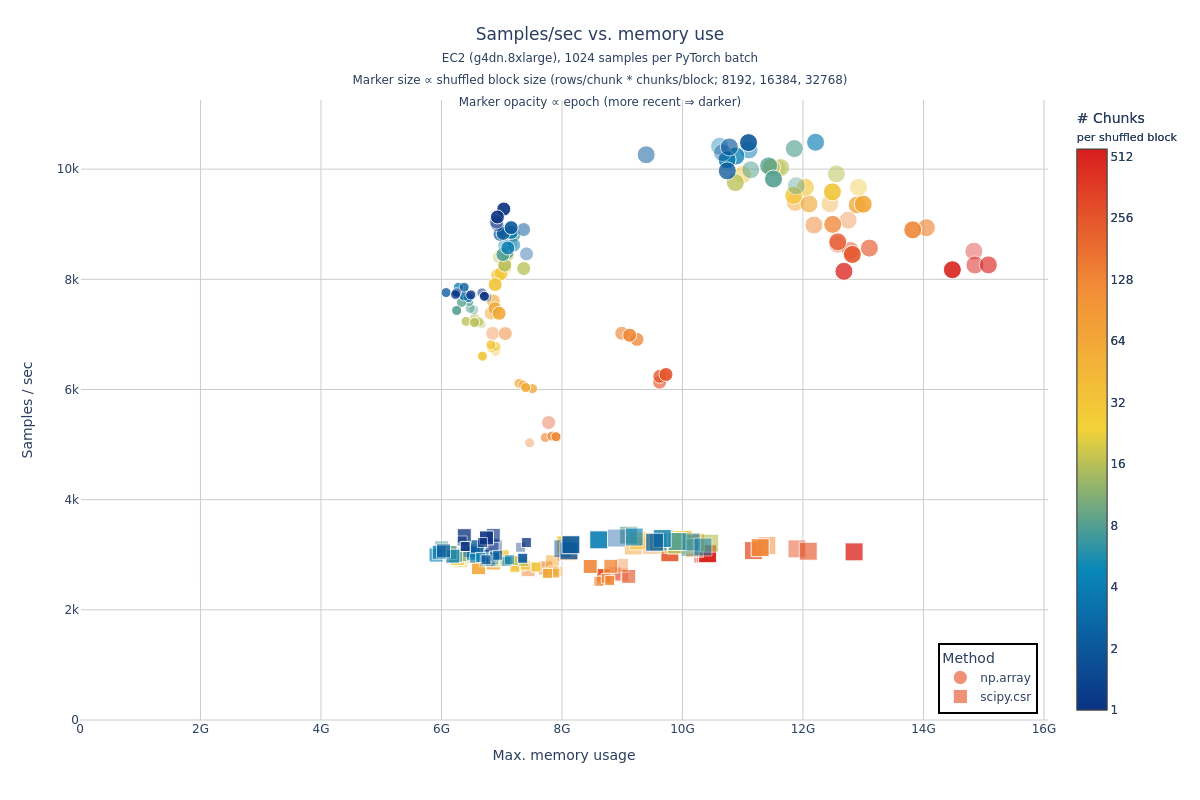

In [17]:
min_size, max_size = 10, 18
fig = go.Figure()
for idx, method in enumerate(METHODS):
    f = df[df.Method == method]
    fig.add_trace(go.Scatter(
        name=method,
        x=f[M],
        y=f[S],
        mode='markers',
        marker=dict(
            color=f.count_lg2,
            colorscale=px.colors.diverging.Portland,
            cmin=min_count_lg2,
            cmax=max_count_lg2 + .12,
            colorbar=colorbar,
            showscale=True,
            opacity=0.4 + 0.5 * f.epoch / df.epoch.max(),
            size=min_size + (max_size - min_size) * (f.block_size_lg2 - min_block_lg2) / (max_block_lg2 - min_block_lg2),
            symbol=symbols[idx],
        ),
        customdata=f[['epoch', 'soma_chunk_size', 'shuffle_chunk_count', 'block_size',]],
    ))

proportional = f'<span style="font-size:{proportional_symbol_size}">∝</span>'
size_text = f'Marker size {proportional} shuffled block size (rows/chunk * chunks/block; {", ".join([ f"{s}" for s in sorted(df.block_size.unique()) ])})'
opacity_text = f'Marker opacity {proportional} epoch (more recent ⇒ darker)'
# fig.add_annotation(
#     x=.99, y=.2,
#     xref="paper", yref="paper",
#     text=size_text,
#     showarrow=False,
# )

plot(
    fig,
    utz.plots.title([
        title,
        host_subtitle,
        size_text,
        opacity_text,
    ], subtitle_size="0.7em"),
    title_y=.95,
    name="speed_vs_mem_1",
    hovertemplate=[
        "Epoch: %{customdata[0]}",
        "Samples/sec: %{y:,d}",
        "Memory: %{x:.3s}",
        "%s: %%{customdata[1]}" % C,
        "Chunks per shuffled block: %{customdata[2]}",
        "Shuffled block size: %{customdata[3]}",
    ],
    xtitle=M,
    xaxis_tickformat='s',
    xaxis_rangemode='tozero',
    ytitle=S,
    legend=dict(
        title_text='Method',
        xanchor='right', x=.99,
        yanchor='bottom', y=.01,
        bordercolor="Black",
        borderwidth=2,
    ),
    zerolines='y',
)